In [1]:
import numpy as np
import pandas as pd
import glob
import xarray as xr
import matplotlib.pyplot as plt
from scipy import stats

import sys; sys.path.insert(1, '/home/alessandro/thesis_material/EURECA_scripts')
import os

import geometry as gm
#import conversion as cnv
from func_statistics import *   #compute_pdf_nbin, slopes_r_p, slope_time, slope_maps
#from coare_functions import *
import meteo
import lcl
import metpy.calc as mpcalc
from metpy.units import units


import cartopy.crs as ccrs
crs = ccrs.PlateCarree()
#from plotmap import plot_background

from plotdistr import * #fb_distribution_npoint, perc_distribution, scatterplot_fit, hist2d
from pdist_fb_distrib_save_fast import *

import warnings; warnings.filterwarnings("ignore")

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# find data
path = '/saturn/simu_Caribbean/coupled_2km/output/'
files_ls = ['QCLOUD', 'U', 'V', 'W', 'OLR', 'PH', 'PHB', 'QVAPOR', 'PB', 'P', 'T']
files_ls = [name + '.nc' for name in files_ls]
wrf_files = [path+name for name in files_ls]
#fname_list = sorted(glob.glob(wrf_files + '*'))

In [4]:
# import sea_mask
if os.path.exists('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_nobnd_EU.npy'):
    sea_mask = np.load('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_nobnd_EU.npy')

if os.path.exists('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_noWarmPatch_noWest.npy'):
    sea_mask_modified = np.load('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_noWarmPatch_noWest.npy')
    sea_mask_modified_nan = np.ones_like(sea_mask_modified)
    sea_mask_modified_nan[sea_mask_modified==0] = np.nan

fourier_mask = np.load('/home/alessandro/thesis_material/EURECA_scripts/masks/fourier_large.npy')


In [5]:
# MATTE AVEVA GIA' CALCOLATO TUTTE LE CORRELAZIONI 
# E HA STIMATO QUESTA LUNGHEZZA?
L = 30
nskip = int(L/2)
nt = int(1)

# from top pbl upwards
# SOPRA PBL LA LUNGEHZZA DI CORRELAZIONE AUMENTA?
# NEL SENSO CHE I SEGNALI HANNO PIù SPAZIO PER PROPAGARSI?
Ltop = 150
nskiptop = int(Ltop/2)
nttop = int(1)

# reference population mean
popmean = 0.
perc_step = 5

In [6]:
wrf_hourly = path + 'Caraibes_WRF_3h_surf.nc'
ds_hourly = xr.open_dataset(wrf_hourly)
ds_hourly = ds_hourly.sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))


sst_day = ds_hourly['SST'].groupby('time_counter.day').mean()            
sst_day = sst_day.where(sea_mask_modified, drop=False).values*fourier_mask; 

# lat and lon
lon = ds_hourly['nav_lon'].values
lat = ds_hourly['nav_lat'].values

### import dsst_day

In [8]:
ds_sst = xr.open_dataset('/venus/tesi_ale/data_EU/SST/hourly/FEB/dSST_feb.nc')
dsst_day = ds_sst['dsst_day']*sea_mask_modified_nan

In [7]:
s = 75

dsst_day = np.zeros(sst_day.shape)

for t in range(0,sst_day.shape[0]):
    if t % 10 == 0:
        print(t)
    
    sst_ave = gm.nan_gaussian_filter(sst_day[t],s)                             
    dsst_day[t] = sst_day[t] - sst_ave

0
10
20


In [1]:
'hello'

'hello'

### build masks for the different dsst regions

In [15]:
dsst_1 = np.nanpercentile(dsst_day, 1)
dsst_20 = np.nanpercentile(dsst_day, 20)
dsst_80 = np.nanpercentile(dsst_day, 80)
dsst_95 = np.nanpercentile(dsst_day, 95)

mask_1  = dsst_day<dsst_1;  mask_1 = np.where(mask_1, 1, np.nan)
mask_20 = dsst_day<dsst_20; mask_20 = np.where(mask_20, 1, np.nan)
mask_80 = dsst_day>dsst_80; mask_80 = np.where(mask_80, 1, np.nan)
mask_95 = dsst_day>dsst_95; mask_95 = np.where(mask_95, 1, np.nan)
mask_between = (dsst_day>dsst_20) & (dsst_day<dsst_80)
mask_between = np.where(mask_between, 1, np.nan)

# masks = [mask_1, mask_20, mask_between, mask_80, mask_95]
# labs_leg = ['1st perc', '20th perc', '80th perc', '95th perc']

In [8]:
### LOAD PRESSURE COLUMN
mean_vert_pres = np.load('/venus/tesi_ale/data_EU/PRES/daily/FEB/mean_vert_pres.npy')

In [11]:
theta = xr.open_dataset(wrf_files[files_ls.index('T.nc')])
theta = theta['T']
theta = theta.sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))
theta = theta.where(sea_mask_modified, drop=False)
theta_day = theta.groupby('time_counter.day').mean()

T0 = 300. 

theta = theta+T0 ;  theta_day = theta_day+T0

In [12]:
theta_day = theta_day.transpose('lev_M', 'day', 'y_grid_M', 'x_grid_M' )

## compute std dev at every level and plot it

Text(0, 0.5, 'pressure [hPa]')

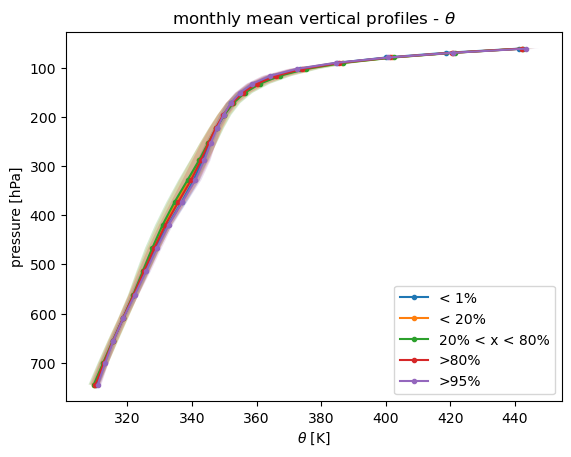

In [43]:
fig, ax = plt.subplots(1)
ax.invert_yaxis()
lev = int(38)

### ADD THE PBLH WITH THE MASKS

masks = [mask_1, mask_20, mask_between, mask_80, mask_95]
labs_leg = ['< 1%', '< 20%', '20% < x < 80%', '>80%', '>95%']

for i in range(5):

    theta_p = theta_day*masks[i]
    theta_std = np.nanstd(theta_p, axis=(1,2,3))
    theta_profile = np.nanmean(theta_p, axis=(1,2,3))
    
    ax.plot(theta_profile[0:lev], mean_vert_pres[0:lev], '.-', label=labs_leg[i])
    ax.fill_betweenx(mean_vert_pres[0:lev], theta_profile[0:lev]+theta_std[0:lev], theta_profile[0:lev]-theta_std[0:lev],\
                     alpha=0.2)
    
    
ax.legend(loc='lower right')
ax.set_title(r'monthly mean vertical profiles - $\theta$')
ax.set_xlabel(r'$\theta$ [K]')
ax.set_ylabel('pressure [hPa]')


In [38]:
qvap = xr.open_dataset(wrf_files[files_ls.index('QVAPOR.nc')])
qvap = qvap['QVAPOR'].sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))
qvap = qvap.where(sea_mask_modified, drop=False)

qvap_day = qvap.groupby('time_counter.day').mean()
qvap_day = qvap_day.transpose('lev_M', 'day', 'y_grid_M', 'x_grid_M' )

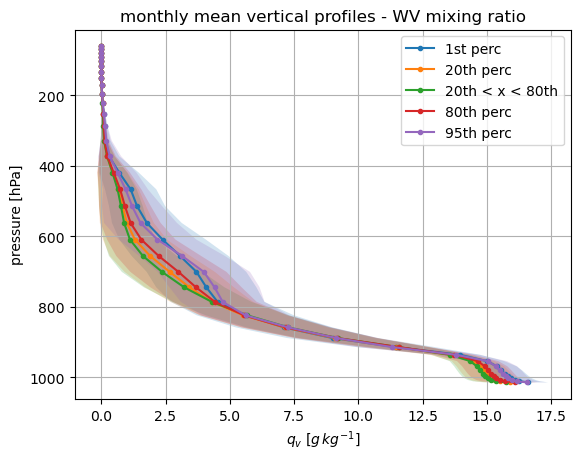

In [41]:
fig, ax = plt.subplots(1)
ax.invert_yaxis()

lev = int(38)
### ADD THE PBLH WITH THE MASKS

masks = [mask_1, mask_20, mask_between, mask_80, mask_95]
labs_leg = ['1st perc', '20th perc', '20th < x < 80th', '80th perc', '95th perc']

for i in range(5):

    qvap_p = qvap_day*masks[i]*1000
    qvap_std = np.nanstd(qvap_p, axis=(1,2,3))
    qvap_profile = np.nanmean(qvap_p, axis=(1,2,3))
    
    ax.plot(qvap_profile[0:lev], mean_vert_pres[0:lev], '.-', label=labs_leg[i])
    ax.fill_betweenx(mean_vert_pres[0:lev], qvap_profile[0:lev]+qvap_std[0:lev], qvap_profile[0:lev]-qvap_std[0:lev],\
                     alpha=0.2)
    
    
ax.legend(loc='upper right')
ax.set_title(r'monthly mean vertical profiles - WV mixing ratio')
ax.set_xlabel(r'$q_v$ [$g\,kg^{-1}$]')
ax.set_ylabel('pressure [hPa]')
ax.grid()

Text(0, 0.5, 'pressure [hPa]')

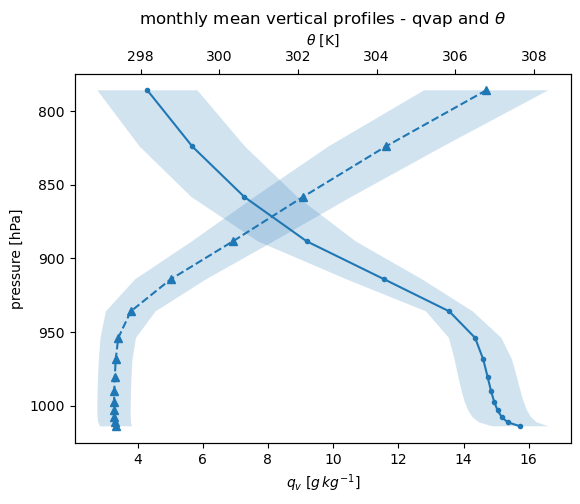

In [69]:
fig, ax = plt.subplots(1)
ax.invert_yaxis()

lev = int(15)
masks = [mask_1, mask_20, mask_80, mask_95]
labs_leg = ['1st perc', '20th perc', '80th perc', '95th perc']

mask_in_use = mask_between


qvap_p = qvap_day*mask_in_use*1000
qvap_std = np.nanstd(qvap_p, axis=(1,2,3))
qvap_profile = np.nanmean(qvap_p, axis=(1,2,3))

ax.plot(qvap_profile[0:lev], mean_vert_pres[0:lev], '.-', label='qvapor')
ax.fill_betweenx(mean_vert_pres[0:lev], qvap_profile[0:lev]+qvap_std[0:lev], qvap_profile[0:lev]-qvap_std[0:lev],\
                     alpha=0.2)


# ax.legend(loc='lower center')
ax.set_title(r'monthly mean vertical profiles - qvap and $\theta$')
ax.set_xlabel(r'$q_v$ [$g\,kg^{-1}$]')
ax.set_ylabel('pressure [hPa]')


ax2 = ax.twiny()

theta_p = theta_day*mask_in_use
theta_std = np.nanstd(theta_p, axis=(1,2,3))
theta_profile = np.nanmean(theta_p, axis=(1,2,3))

ax2.plot(theta_profile[0:lev], mean_vert_pres[0:lev], '^--')
ax2.fill_betweenx(mean_vert_pres[0:lev], theta_profile[0:lev]+theta_std[0:lev], theta_profile[0:lev]-theta_std[0:lev],\
                   alpha=0.2)
    
# ax2.legend(loc='lower center')
# ax2.set_title('monthly mean vertical profiles - qvap')
ax2.set_xlabel(r'$\theta$ [K]')
ax2.set_ylabel('pressure [hPa]')

In [7]:
pres_base = xr.open_dataset(wrf_files[files_ls.index('PB.nc')])
pres_base = pres_base['PB']

pres = xr.open_dataset(wrf_files[files_ls.index('P.nc')])
pres = pres['P'].sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))

In [8]:
pres = (pres+pres_base)/100.                # hectoPascals
pres = pres.where(sea_mask_modified, drop=False)

del pres_base

In [11]:
temperature = theta * ( pres / 1000. )**0.286
temperature = temperature.where(sea_mask_modified, drop=False)

del pres

In [12]:
temperature = xr.DataArray(temperature, dims=['time_counter', 'lev_M', 'lat', 'lon'], name='temperature', coords={'time_counter':theta.time_counter})
temperature.attrs['long_name'] = 'actual air temperature offshore, 3h'
temperature.attrs['unit'] = 'K'


ds_out_temperature = xr.Dataset({
    'temperature': temperature})

ds_out_temperature.to_netcdf('/venus/tesi_ale/data_EU/T/hourly/FEB/temperature_3h.nc')

In [2]:
temperature = xr.open_dataset('/venus/tesi_ale/data_EU/T/hourly/FEB/temperature_3h.nc')
temperature = temperature['temperature']

In [ ]:
fig, ax = plt.subplots(1)
ax.invert_yaxis()

lev = int(38)
### ADD THE PBLH WITH THE MASKS

masks = [mask_1, mask_20, mask_between, mask_80, mask_95]
labs_leg = ['1st perc', '20th perc', '20th < x < 80th', '80th perc', '95th perc']

for i in range(5):

    temperature_p = temperature_day*masks[i]*1000
    temperature_std = np.nanstd(temperature_p, axis=(1,2,3))
    temperature_profile = np.nanmean(temperature_p, axis=(1,2,3))
    
    ax.plot(temperature_profile[0:lev], mean_vert_pres[0:lev], '.-', label=labs_leg[i])
    ax.fill_betweenx(mean_vert_pres[0:lev], temperature_profile[0:lev]+temperature_std[0:lev], temperature_profile[0:lev]-temperature_std[0:lev],\
                     alpha=0.2)
    
    
ax.legend(loc='upper right')
ax.set_title(r'monthly mean vertical profiles - temperature')
ax.set_xlabel(r'T [K]')
ax.set_ylabel('pressure [hPa]')
ax.grid()

# COMPUTING EQUIVAL THETA

In [15]:
Lv = 2.5e+6   # J / kg
cp = 1005.    # J / kg K

exponent = (Lv*qvap.values/(cp*temperature.values))


In [16]:
factor = np.exp(exponent)

In [17]:
factor = xr.DataArray(factor, dims=['time_counter', 'lev_M', 'lat', 'lon'], name='LCL_day')
factor.attrs['long_name'] = 'np.exp(Lq/c_p T), for computation of theta_e'
factor.attrs['unit'] = 'unitless'


ds_out = xr.Dataset({
    'factor': factor})

ds_out.to_netcdf('/venus/tesi_ale/data_EU/T/hourly/FEB/factor_for_thetaE.nc')

In [11]:
factor = xr.open_dataset('/venus/tesi_ale/data_EU/T/hourly/FEB/factor_for_thetaE.nc')

In [14]:
equiv_theta = theta.values*factor['factor'].values

In [19]:
equiv_theta = xr.DataArray(equiv_theta, dims=['time_counter', 'lev_M', 'lat', 'lon'], name='equiv_theta',\
                           coords={
                                'time_counter': theta.time_counter})

equiv_theta.attrs['long_name'] = '3h equivalent potential temperature'
equiv_theta.attrs['unit'] = 'K'

In [20]:
equiv_theta_day = equiv_theta.groupby('time_counter.day').mean()

In [21]:
equiv_theta_day = xr.DataArray(equiv_theta_day, dims=['day', 'lev_M', 'lat', 'lon'], name='equiv_theta_day')

equiv_theta_day.attrs['long_name'] = 'daily average equivalent potential temperature'
equiv_theta_day.attrs['unit'] = 'K'

In [23]:
ds_out_theta = xr.Dataset({
    'equiv_theta': equiv_theta, 
    'equiv_theta_day': equiv_theta_day})

ds_out_theta.to_netcdf('/venus/tesi_ale/data_EU/T/hourly/FEB/equiv_theta.nc') 

# END OF COMPUTING EQUIV THETA

In [9]:
equiv_theta_day = xr.open_dataset('/venus/tesi_ale/data_EU/T/hourly/FEB/equiv_theta.nc')
equiv_theta_day = equiv_theta_day['equiv_theta_day']*sea_mask_modified_nan

equiv_theta_day = equiv_theta_day.transpose('day', 'lev_M', 'lat', 'lon')

Text(0, 0.5, 'pressure [hPa]')

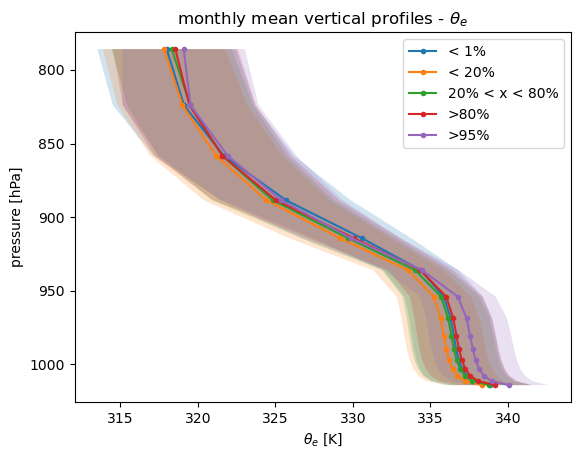

In [16]:
fig, ax = plt.subplots(1)
ax.invert_yaxis()
lev = int(15)

### ADD THE PBLH WITH THE MASKS

masks = [mask_1, mask_20, mask_between, mask_80, mask_95]
labs_leg = ['< 1%', '< 20%', '20% < x < 80%', '>80%', '>95%']
# equiv_theta_day = equiv_theta_day.transpose('lev_M', 'day', 'lat', 'lon')

for i in range(5):

    equiv_theta_p = equiv_theta_day*masks[i]
    equiv_theta_std = np.nanstd(equiv_theta_p, axis=(1,2,3))
    equiv_theta_profile = np.nanmean(equiv_theta_p, axis=(1,2,3))
    
    ax.plot(equiv_theta_profile[0:lev], mean_vert_pres[0:lev], '.-', label=labs_leg[i])
    ax.fill_betweenx(mean_vert_pres[0:lev], equiv_theta_profile[0:lev]+equiv_theta_std[0:lev], equiv_theta_profile[0:lev]-equiv_theta_std[0:lev],\
                     alpha=0.2)
    
    
ax.legend(loc='upper right')
ax.set_title(r'monthly mean vertical profiles - $\theta_e$')
ax.set_xlabel(r'$\theta_e$ [K]')
ax.set_ylabel('pressure [hPa]')
# ax.grid()


In [33]:
PBLH_day = ds_hourly['PBLH'].groupby('time_counter.day').mean()            
PBLH_day = PBLH_day.where(sea_mask_modified, drop=False).values*fourier_mask; 

# PBLH IN PRESSURE VALUES! 
# output is in hPa
PBLH_pres = mpcalc.height_to_pressure_std(PBLH_day*units.meters)
PBLH_pres = PBLH_pres.magnitude #.m_as('hPa')

In [34]:
perc_step = 2
nbins = int(100/perc_step) # Number of bins.


pdist_dsst, pdist_PBLH_dsst, pstd_PBLH_dsst, pstderr_PBLH_dsst, pnpoints_PBLH_dsst, ppvalue_PBLH_dsst = \
distrib_2d(dsst_day, PBLH_pres, perc_step, nbins, popmean, 'perc')

In [32]:
perc_step = 2
nbins = int(100/perc_step) # Number of bins.

pdist_dsst, pdist_ThE_dsst, pstd_ThE_dsst, pstderr_ThE_dsst, pnpoints_ThE_dsst, ppvalue_ThE_dsst_sub = \
dist_3d_subsample(dsst_day, equiv_theta_day.values, perc_step, nbins, popmean, nt, nttop, nskip, nskiptop, top=14, perc_fixbin='perc')

0
10
20
30


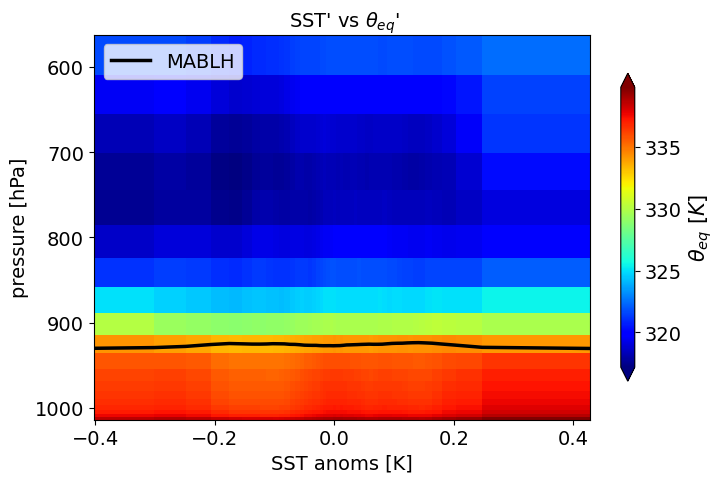

In [39]:
# figure dBV or BV vs dSST bin - DAILY
p_level_plot = int(20)


x = pdist_dsst   
var = pdist_ThE_dsst[0:p_level_plot,:]    
# minval = .
# maxval = -minval
# title = '100km'

fig, ax1 = plt.subplots(figsize=(8, 5))  


ax1.invert_yaxis()
p1 = ax1.pcolormesh(x, mean_vert_pres[0:p_level_plot], var, cmap='jet') 
ax1.set_xlabel('SST anoms [K]', fontsize=14)
ax1.set_ylabel('pressure [hPa]', fontsize=14)
ax1.set_title(r" SST' vs $\theta_{eq}$'", fontsize=14)
cbar = plt.colorbar(p1,ax=ax1, location='right', shrink=0.8, extend='both', pad=0.05)  
cbar.set_label(r'$\theta_{eq}$ [$K$]', fontsize=15)
cbar.ax.tick_params(labelsize=14)


x_pbl = x                         
var_pbl = pdist_PBLH_dsst    
ax1.plot(x_pbl, var_pbl, 'k', linewidth=2.5, label='MABLH')
ax1.legend(fontsize=14, loc='upper left')


ax1.tick_params(axis='x', labelsize=14) 
ax1.tick_params(axis='y', labelsize=14)


# DEF punti significativi (pvalue < 0.05)
pval = ppvalue_ThE_dsst_sub[0:p_level_plot]  # ppvalue_dBV_oo_sub         #ppvalue_BV_freq_sub ppvalue_dBV_freq_day_sub 
GPbin = mean_vert_pres[1:p_level_plot] - np.diff(mean_vert_pres[0:p_level_plot])*0.5
signif_Lcorr_H = np.zeros((len(mean_vert_pres[0:p_level_plot])-1,len(x)-1))
dsstbin = np.zeros((len(mean_vert_pres[0:p_level_plot])-1,len(x)-1))
for h in range(0,len(mean_vert_pres[0:p_level_plot])-1):
    cond1 = pval[h,:-1] > 0.05
    cond2 = np.abs(var[h,:-1]) < 0.1*np.nanmean(np.abs(var))
    cond = (cond1) | (cond2)
#     cond = cond1
    signif_Lcorr_H[h,:] = np.zeros(len(x)-1) + np.nan
    signif_Lcorr_H[h, cond] = GPbin[h]
    dsstbin[h,:] = x[1:] - np.diff(x)*0.5
    
ax1.scatter(dsstbin,signif_Lcorr_H,  s=0.7, color='k')

# compute N2 in terms of ThetaE

In [10]:
# reading geopotential height
GPH_base = xr.open_dataset(wrf_files[files_ls.index('PHB.nc')])
GPH_base = GPH_base['PHB']/9.81


In [ ]:
GPH = xr.open_dataset(wrf_files[files_ls.index('PH.nc')])
GPH = GPH.sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))
GPH = GPH['PH']/9.81


In [ ]:
GPH = GPH_base + GPH
GPH = GPH.transpose('time_counter', 'lev_W', 'y_grid_M', 'x_grid_M')
GPH = GPH.where(sea_mask_modified, drop=False)

GPH = GPH.groupby('time_counter.day').mean()

del GPH_base

In [40]:
# vertical interpolation of geopotential
GPH_inter = np.zeros_like(equiv_theta_day)
for i in range(39):
    GPH_inter[:,i,:,:] = (GPH[:,i+1,:,:]+GPH[:,i,:,:])*0.5

In [56]:
N2_equiv = mpcalc.brunt_vaisala_frequency_squared(GPH_inter*units.meters, equiv_theta_day.values*units.kelvin, vertical_dim = 1)

In [49]:
s = 100

dN2Equiv = np.zeros(equiv_theta_day.shape)

for t in range(0,equiv_theta_day.shape[0]):
    if t % 10 == 0:
        print(t)
    for h in range(0,20):
        bv_ave = gm.nan_gaussian_filter(N2_equiv[t,h].magnitude, s)                               
        dN2Equiv[t,h] = N2_equiv[t,h].magnitude - bv_ave

0
10
20


In [50]:
perc_step = 2
nbins = int(100/perc_step) # Number of bins.

pdist_dsst, pdist_dN2Equiv, pstd_dN2Equiv, pstderr_dN2Equiv, pnpoints_dN2Equiv, ppvalue_dN2Equiv_sub = \
dist_3d_subsample(dsst_day, dN2Equiv, perc_step, nbins, popmean, nt, nttop, nskip, nskiptop, top=14, perc_fixbin='perc')

0
10
20
30


In [46]:
np.nanmax(dN2Equiv)

12.513771604539272

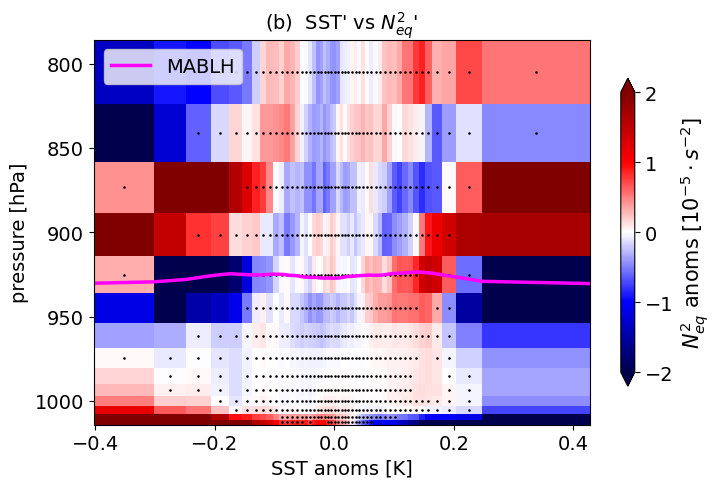

In [54]:
# figure dBV or BV vs dSST bin - DAILY
p_level_plot = int(15)


x = pdist_dsst   
var = pdist_dN2Equiv[0:p_level_plot,:]*1e5 #    
minval = -2.
maxval = -minval
# title = '100km'

fig, ax1 = plt.subplots(figsize=(8, 5))  


ax1.invert_yaxis()
p1 = ax1.pcolormesh(x, mean_vert_pres[0:p_level_plot], var, vmin=minval, vmax=maxval, cmap='seismic')
ax1.set_xlabel('SST anoms [K]', fontsize=14)
ax1.set_ylabel('pressure [hPa]', fontsize=14)
ax1.set_title(r"(b)  SST' vs $N^2_{eq}$'", fontsize=14)
cbar = plt.colorbar(p1,ax=ax1, location='right', shrink=0.8, extend='both', pad=0.05)  
cbar.set_label(r'$N^2_{eq}$ anoms [$10^{-5} \cdot s^{-2}$]', fontsize=15)
cbar.ax.tick_params(labelsize=14)


x_pbl = x                         
var_pbl = pdist_PBLH_dsst    
ax1.plot(x_pbl, var_pbl, 'magenta', linewidth=2.5, label='MABLH')
ax1.legend(fontsize=14, loc='upper left')


ax1.tick_params(axis='x', labelsize=14) 
ax1.tick_params(axis='y', labelsize=14)


# DEF punti significativi (pvalue < 0.05)
pval = ppvalue_dN2Equiv_sub[0:p_level_plot]  # ppvalue_dBV_oo_sub         #ppvalue_BV_freq_sub ppvalue_dBV_freq_day_sub 
GPbin = mean_vert_pres[1:p_level_plot] - np.diff(mean_vert_pres[0:p_level_plot])*0.5
signif_Lcorr_H = np.zeros((len(mean_vert_pres[0:p_level_plot])-1,len(x)-1))
dsstbin = np.zeros((len(mean_vert_pres[0:p_level_plot])-1,len(x)-1))
for h in range(0,len(mean_vert_pres[0:p_level_plot])-1):
    cond1 = pval[h,:-1] > 0.05
    cond2 = np.abs(var[h,:-1]) < 0.1*np.nanmean(np.abs(var))
    cond = (cond1) | (cond2)
#     cond = cond1
    signif_Lcorr_H[h,:] = np.zeros(len(x)-1) + np.nan
    signif_Lcorr_H[h, cond] = GPbin[h]
    dsstbin[h,:] = x[1:] - np.diff(x)*0.5
    
ax1.scatter(dsstbin,signif_Lcorr_H,  s=0.7, color='k')


# path_img = '/venus/tesi_ale/img_EU/BV/daily/FEB/' #if perc else '/venus/tesi_ale/img_EU/BV/daily/FEB/'
# filename = path_img + 'NEW_pdist_dsst_BV_lowtropo_openOcean.png' #if perc else path_img + 'bins_dsst_dBV_lowtropo.png'
# # plt.savefig(filename)
# print(filename)
# del filename

In [58]:
perc_step = 2
nbins = int(100/perc_step) # Number of bins.

pdist_dsst, pdist_N2Eq_dsst, pstd_N2Eq_dsst, pstderr_N2Eq_dsst, pnpoints_N2Eq_dsst, ppvalue_N2Eq_dsst_sub = \
dist_3d_subsample(dsst_day, N2_equiv.magnitude, perc_step, nbins, popmean, nt, nttop, nskip, nskiptop, top=14, perc_fixbin='perc')

0
10
20
30


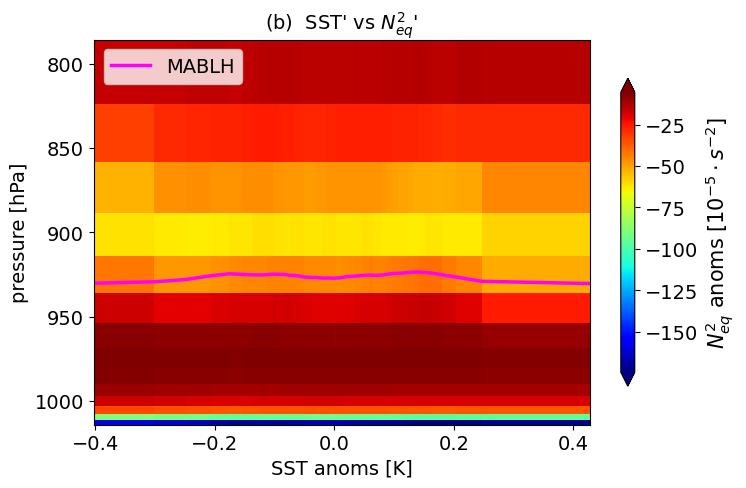

In [60]:
# figure dBV or BV vs dSST bin - DAILY
p_level_plot = int(15)


x = pdist_dsst   
var = pdist_N2Eq_dsst[0:p_level_plot,:]*1e5 #    
minval = -10.
maxval = -minval
# title = '100km'

fig, ax1 = plt.subplots(figsize=(8, 5))  


ax1.invert_yaxis()
p1 = ax1.pcolormesh(x, mean_vert_pres[0:p_level_plot], var, cmap='jet')# vmin=minval, vmax=maxval, cmap='seismic')
ax1.set_xlabel('SST anoms [K]', fontsize=14)
ax1.set_ylabel('pressure [hPa]', fontsize=14)
ax1.set_title(r"(b)  SST' vs $N^2_{eq}$'", fontsize=14)
cbar = plt.colorbar(p1,ax=ax1, location='right', shrink=0.8, extend='both', pad=0.05)  
cbar.set_label(r'$N^2_{eq}$ anoms [$10^{-5} \cdot s^{-2}$]', fontsize=15)
cbar.ax.tick_params(labelsize=14)


x_pbl = x                         
var_pbl = pdist_PBLH_dsst    
ax1.plot(x_pbl, var_pbl, 'magenta', linewidth=2.5, label='MABLH')
ax1.legend(fontsize=14, loc='upper left')


ax1.tick_params(axis='x', labelsize=14) 
ax1.tick_params(axis='y', labelsize=14)


# DEF punti significativi (pvalue < 0.05)
# pval = ppvalue_dN2Equiv_sub[0:p_level_plot]  # ppvalue_dBV_oo_sub         #ppvalue_BV_freq_sub ppvalue_dBV_freq_day_sub 
# GPbin = mean_vert_pres[1:p_level_plot] - np.diff(mean_vert_pres[0:p_level_plot])*0.5
# signif_Lcorr_H = np.zeros((len(mean_vert_pres[0:p_level_plot])-1,len(x)-1))
# dsstbin = np.zeros((len(mean_vert_pres[0:p_level_plot])-1,len(x)-1))
# for h in range(0,len(mean_vert_pres[0:p_level_plot])-1):
#     cond1 = pval[h,:-1] > 0.05
#     cond2 = np.abs(var[h,:-1]) < 0.1*np.nanmean(np.abs(var))
#     cond = (cond1) | (cond2)
# #     cond = cond1
#     signif_Lcorr_H[h,:] = np.zeros(len(x)-1) + np.nan
#     signif_Lcorr_H[h, cond] = GPbin[h]
#     dsstbin[h,:] = x[1:] - np.diff(x)*0.5
    
# ax1.scatter(dsstbin,signif_Lcorr_H,  s=0.7, color='k')


# path_img = '/venus/tesi_ale/img_EU/BV/daily/FEB/' #if perc else '/venus/tesi_ale/img_EU/BV/daily/FEB/'
# filename = path_img + 'NEW_pdist_dsst_BV_lowtropo_openOcean.png' #if perc else path_img + 'bins_dsst_dBV_lowtropo.png'
# # plt.savefig(filename)
# print(filename)
# del filename

In [ ]:
qvap = xr.open_dataset(wrf_files[files_ls.index('QVAPOR.nc')])
qvap = qvap['QVAPOR'].sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))
qvap = qvap.where(sea_mask_modified, drop=False)

qvap_day = qvap.groupby('time_counter.day').mean()
qvap_day = qvap_day.transpose('lev_M', 'day', 'y_grid_M', 'x_grid_M' )

#### from the TropMet notes: instability in the moist sense may be expressed throught the lapse rate of the Saturated Equivalent potential temperature

# COMPUTING SAT EQUIV THETA

In [ ]:
'''qsat = mpcalc.saturation_mixing_ratio(pres.values*units.hPa,temperature.values*units.kelvin).to('kg/kg')'''

In [3]:
qsat = xr.open_dataset('/venus/tesi_ale/data_EU/QVAPOR/hourly/FEB/qsat_3h.nc')
qsat = qsat['qsat']

In [4]:
Lv = 2.5e+6   # J / kg
cp = 1005.    # J / kg K

exponent = (Lv*qsat.values/(cp*temperature.values))


In [5]:
factor_sat = np.exp(exponent)

In [6]:
factor_sat = xr.DataArray(factor_sat, dims=['time_counter', 'lev_M', 'lat', 'lon'], name='factor_sat')
factor_sat.attrs['long_name'] = 'np.exp(Lq*/c_p T), for computation of sat_theta_e'
factor_sat.attrs['unit'] = 'unitless'


ds_out = xr.Dataset({
    'factor_sat': factor_sat})

ds_out.to_netcdf('/venus/tesi_ale/data_EU/T/hourly/FEB/factor_sat_for_thetaE.nc')

In [11]:
factor_sat = xr.open_dataset('/venus/tesi_ale/data_EU/T/hourly/FEB/factor_sat_for_thetaE.nc')
factor_sat = factor_sat['factor_sat'].values

In [12]:
sat_theta_e = theta*factor_sat

In [19]:
sat_theta_e = xr.DataArray(sat_theta_e, dims=['time_counter', 'lev_M', 'lat', 'lon'], name='sat_theta_e',\
                           coords={
                                'time_counter': theta.time_counter})

sat_theta_e.attrs['long_name'] = '3h saturated equivalent potential temperature'
sat_theta_e.attrs['unit'] = 'K'

In [16]:
sat_theta_e_day = sat_theta_e.groupby('time_counter.day').mean()

In [21]:
sat_theta_e_day = xr.DataArray(sat_theta_e_day, dims=['day', 'lev_M', 'lat', 'lon'], name='sat_theta_e_day')

sat_theta_e_day.attrs['long_name'] = 'daily average saturated equivalent potential temperature'
sat_theta_e_day.attrs['unit'] = 'K'

In [23]:
ds_out_sattheta = xr.Dataset({
    'sat_theta_e': sat_theta_e, 
    'sat_theta_e_day': sat_theta_e_day})

ds_out_sattheta.to_netcdf('/venus/tesi_ale/data_EU/T/hourly/FEB/sat_theta_e.nc') 

# END OF COMPUTING SAT THETA EQUIV

In [19]:
ds_sat_theta = xr.open_dataset('/venus/tesi_ale/data_EU/T/hourly/FEB/sat_theta_e.nc')
sat_theta_e_day = ds_sat_theta['sat_theta_e_day']

In [20]:
type(sat_theta_e_day)

xarray.core.dataarray.DataArray

Text(0, 0.5, 'pressure [hPa]')

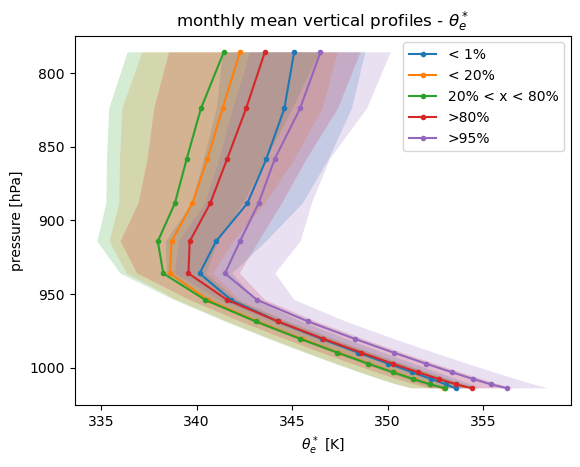

In [21]:
fig, ax = plt.subplots(1)
ax.invert_yaxis()
lev = int(15)

### ADD THE PBLH WITH THE MASKS

masks = [mask_1, mask_20, mask_between, mask_80, mask_95]
labs_leg = ['< 1%', '< 20%', '20% < x < 80%', '>80%', '>95%']
sat_theta_e_day = sat_theta_e_day.transpose('lev_M', 'day', 'lat', 'lon')

for i in range(5):

    sat_theta_e_p = sat_theta_e_day*masks[i]
    sat_theta_e_std = np.nanstd(sat_theta_e_p, axis=(1,2,3))
    sat_theta_e_profile = np.nanmean(sat_theta_e_p, axis=(1,2,3))
    
    ax.plot(sat_theta_e_profile[0:lev], mean_vert_pres[0:lev], '.-', label=labs_leg[i])
    ax.fill_betweenx(mean_vert_pres[0:lev], sat_theta_e_profile[0:lev]+sat_theta_e_std[0:lev], sat_theta_e_profile[0:lev]-sat_theta_e_std[0:lev],\
                     alpha=0.2)
    
    
ax.legend(loc='upper right')
ax.set_title(r'monthly mean vertical profiles - $\theta^*_e$')
ax.set_xlabel(r'$\theta^*_e$ [K]')
ax.set_ylabel('pressure [hPa]')
# ax.grid()


In [ ]:
##### comparing theta_e and sat_theta_e profiles

In [22]:
equiv_theta_day = equiv_theta_day.transpose('lev_M', 'day', 'lat', 'lon')
sat_theta_e_day = sat_theta_e_day.transpose('lev_M', 'day', 'lat', 'lon')

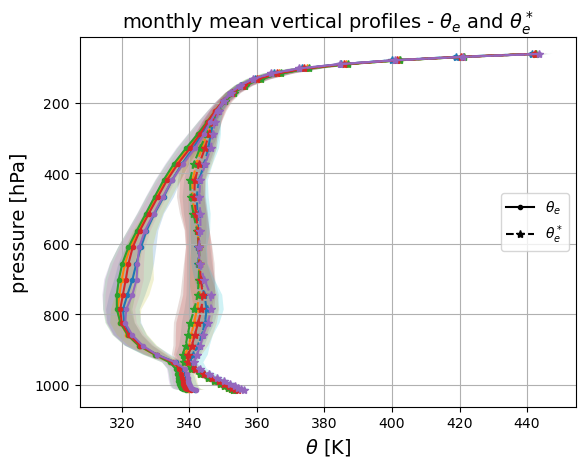

In [26]:
import matplotlib.lines as mlines

fig, ax = plt.subplots(1)
ax.invert_yaxis()
lev = int(38)

### ADD THE PBLH WITH THE MASKS

masks = [mask_1, mask_20, mask_between, mask_80, mask_95]
labs_leg = ['< 1%', '< 20%', '20% < x < 80%', '>80%', '>95%']
equiv_theta_day = equiv_theta_day.transpose('lev_M', 'day', 'lat', 'lon')

# colors=['blue', 'orange']

for i in range(5):

    equiv_theta_p = equiv_theta_day*masks[i]
    equiv_theta_std = np.nanstd(equiv_theta_p, axis=(1,2,3))
    equiv_theta_profile = np.nanmean(equiv_theta_p, axis=(1,2,3))
    
    col = ax.plot(equiv_theta_profile[0:lev], mean_vert_pres[0:lev], '.-', label=labs_leg[i])
    ax.fill_betweenx(mean_vert_pres[0:lev], equiv_theta_profile[0:lev]+equiv_theta_std[0:lev], equiv_theta_profile[0:lev]-equiv_theta_std[0:lev],\
                     alpha=0.2)
    
    col = col[0].get_color()
    
    sat_theta_e_p = sat_theta_e_day*masks[i]
    sat_theta_e_std = np.nanstd(sat_theta_e_p, axis=(1,2,3))
    sat_theta_e_profile = np.nanmean(sat_theta_e_p, axis=(1,2,3))
    
    ax.plot(sat_theta_e_profile[0:lev], mean_vert_pres[0:lev], '*--', label=labs_leg[i], color=col)
    ax.fill_betweenx(mean_vert_pres[0:lev], sat_theta_e_profile[0:lev]+sat_theta_e_std[0:lev], sat_theta_e_profile[0:lev]-sat_theta_e_std[0:lev],\
                     alpha=0.2)
    
# Custom legend handles
dot_handle = mlines.Line2D([], [], color='black', marker='.', linestyle='-', label=r'$\theta_e$')
asterisk_handle = mlines.Line2D([], [], color='black', marker='*', linestyle='--', label=r'$\theta^*_e$')

# Add the custom legend
ax.legend(handles=[dot_handle, asterisk_handle], loc='center right')


ax.set_title(r'monthly mean vertical profiles - $\theta_e$ and $\theta^*_e$', fontsize=14)
ax.set_xlabel(r'$\theta$ [K]',  fontsize=14)
ax.set_ylabel('pressure [hPa]',  fontsize=14)
ax.grid()


# EVALUATE ENTRAINMENT ACCORDING TO WOOD BRETHERTON 2004

In [ ]:
# load U component
U_day = xr.open_dataset(wrf_files[files_ls.index('U.nc')])
U_day = U_day['U'].sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000')).groupby('time_counter.day').mean()

i = np.arange(0, sea_mask.shape[1])
U_day = 0.5*(U_day[:,:,:,i] + U_day[:,:,:,i+1])

In [ ]:
# select data oversea
U_day = U_day.where(sea_mask_modified, drop=False)

In [ ]:
# load U component
V_day = xr.open_dataset(wrf_files[files_ls.index('V.nc')])
V_day = V_day['V'].sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-03-01T01:30:00.000000000')).groupby('time_counter.day').mean()

j = np.arange(0, sea_mask.shape[0])
V_day = 0.5*(V_day[:,:,j,:] + V_day[:,:,j+1,:])

In [ ]:
# select data oversea
V_day = V_day.where(sea_mask_modified, drop=False)